# Task 2: Machine Learning Model for Customer Churn Prediction

### Loading Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, 
                            confusion_matrix, 
                            roc_auc_score,
                            precision_recall_curve)
from imblearn.over_sampling import SMOTE
import joblib
import json

# Load data with rigorous validation
try:
    df = pd.read_csv("C:\\Users\\91739\\Downloads\\Customer_Churn_Data_Large (1).csv")
    assert not df.empty, "ERROR: Empty dataset"
    print("✅ Data loaded successfully. Shape:", df.shape)
except Exception as e:
    print(f"🚨 Data loading failed: {str(e)}")
    exit()

✅ Data loaded successfully. Shape: (1000, 5)


In [2]:
# Check first 5 rows
print(df.head())

   CustomerID  Age Gender MaritalStatus IncomeLevel
0           1   62      M        Single         Low
1           2   65      M       Married         Low
2           3   18      M        Single         Low
3           4   21      M       Widowed         Low
4           5   21      M      Divorced      Medium


###  2. Data Quality Check

In [3]:
def data_audit(df):
    """Generate data quality report"""
    audit = pd.DataFrame({
        'dtype': df.dtypes,
        'missing_values': df.isnull().sum(),
        'unique_values': df.nunique(),
        'sample_values': [df[col].unique()[:3] for col in df.columns]
    })
    return audit

data_quality_report = data_audit(df)
print("\n🔍 Data Quality Report:")
print(data_quality_report)


🔍 Data Quality Report:
                dtype  missing_values  unique_values  \
CustomerID      int64               0           1000   
Age             int64               0             52   
Gender         object               0              2   
MaritalStatus  object               0              4   
IncomeLevel    object               0              3   

                            sample_values  
CustomerID                      [1, 2, 3]  
Age                          [62, 65, 18]  
Gender                             [M, F]  
MaritalStatus  [Single, Married, Widowed]  
IncomeLevel           [Low, Medium, High]  


### 3. Feature Engineering

In [4]:
# Strategic feature creation
df['Is_Young'] = (df['Age'] < 30).astype(int)
df['Is_Senior'] = (df['Age'] > 60).astype(int)

# Targeted encoding based on EDA
income_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['IncomeLevel_encoded'] = df['IncomeLevel'].map(income_map)

# High-risk segment flag
df['High_Risk'] = ((df['Is_Young'] == 1) & 
                   (df['IncomeLevel'] == 'Low')).astype(int)

### 4. Target Variable Engineering

In [5]:
# IMPORTANT: Replace this with real churn data when available
# Current implementation uses synthetic flags for demonstration
np.random.seed(42)
churn_prob = 0.15 + 0.25*df['Is_Young'] + 0.1*(df['IncomeLevel'] == 'Low')
df['Churn'] = np.random.binomial(1, churn_prob)

print("\n🎯 Churn Distribution (Synthetic):")
print(df['Churn'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))


🎯 Churn Distribution (Synthetic):
Churn
0    76.2%
1    23.8%
Name: proportion, dtype: object


### 5. Model Development
### ======================

In [6]:
# Prepare data
X = pd.get_dummies(df.drop(['CustomerID', 'Churn'], axis=1))
y = df['Churn']

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Handle imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Model training with hyperparameter tuning
params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

model = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=params,
    cv=5,
    scoring='recall'
)
model.fit(X_res, y_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='recall')

### 6. Model Evaluation

In [8]:
def generate_performance_report(model, X_test, y_test):
    """Generate comprehensive evaluation metrics"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Classification metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    
    return {
        'classification_report': report,
        'confusion_matrix': cm.tolist(),
        'roc_auc': roc_auc,
        'best_params': model.best_params_,
        'feature_importances': dict(zip(X.columns, model.best_estimator_.feature_importances_))
    }

performance = generate_performance_report(model, X_test, y_test)

### 7. Insight Generation

In [9]:
def generate_insights(performance, df):
    """Transform model outputs into business insights"""
    features = pd.DataFrame({
        'feature': performance['feature_importances'].keys(),
        'importance': performance['feature_importances'].values()
    }).sort_values('importance', ascending=False)
    
    # Key risk segments
    high_risk = df.groupby(['Is_Young', 'IncomeLevel'])['Churn'].mean()
    
    return {
        'top_5_features': features.head(5).to_dict('records'),
        'high_risk_segments': high_risk.to_dict(),
        'model_recall': performance['classification_report']['1']['recall'],
        'model_precision': performance['classification_report']['1']['precision']
    }

insights = generate_insights(performance, df)

### 8. Output Generation

In [15]:
def convert_for_json(obj):
    import numpy as np
    import pandas as pd
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    if isinstance(obj, (np.dtype, pd.api.extensions.ExtensionDtype)):
        return str(obj)
    if hasattr(obj, 'tolist'):
        return obj.tolist()
    return str(obj)

def tuple_keys_to_str(d):
    if isinstance(d, dict):
        return {str(k): tuple_keys_to_str(v) for k, v in d.items()}
    return d

insights_fixed = insights.copy()
if 'high_risk_segments' in insights_fixed:
    insights_fixed['high_risk_segments'] = tuple_keys_to_str(insights_fixed['high_risk_segments'])

dqr_fixed = data_quality_report.copy()
dqr_fixed['dtype'] = dqr_fixed['dtype'].astype(str)

outputs = {
    'data_quality': dqr_fixed.astype(object).applymap(convert_for_json).to_dict(),
    'model_performance': json.loads(json.dumps(performance, default=convert_for_json)),
    'business_insights': json.loads(json.dumps(insights_fixed, default=convert_for_json))
}

with open('model_outputs.json', 'w') as f:
    json.dump(outputs, f, indent=2)

joblib.dump(model.best_estimator_, 'churn_model.pkl')

print("\n🚀 Analysis Complete. Key Outputs:")
print("- model_outputs.json (All metrics)")
print("- churn_model.pkl (Trained model)")
print("\n🔑 Top Business Insights:")
for k, v in insights_fixed.items():
    print(f"- {k}: {v}")

C:\Users\91739\AppData\Local\Temp\ipykernel_24216\3894408401.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  'data_quality': dqr_fixed.astype(object).applymap(convert_for_json).to_dict(),



🚀 Analysis Complete. Key Outputs:
- model_outputs.json (All metrics)
- churn_model.pkl (Trained model)

🔑 Top Business Insights:
- top_5_features: [{'feature': 'Age', 'importance': 0.3922834499984603}, {'feature': 'Gender_M', 'importance': 0.06979109613733582}, {'feature': 'MaritalStatus_Widowed', 'importance': 0.06787955388038497}, {'feature': 'Gender_F', 'importance': 0.06524923955574187}, {'feature': 'MaritalStatus_Divorced', 'importance': 0.06308973767246989}]
- high_risk_segments: {"(0, 'High')": 0.13307984790874525, "(0, 'Low')": 0.24279835390946503, "(0, 'Medium')": 0.172, "(1, 'High')": 0.36046511627906974, "(1, 'Low')": 0.5487804878048781, "(1, 'Medium')": 0.32894736842105265}
- model_recall: 0.23943661971830985
- model_precision: 0.2982456140350877


### 9. Visualization

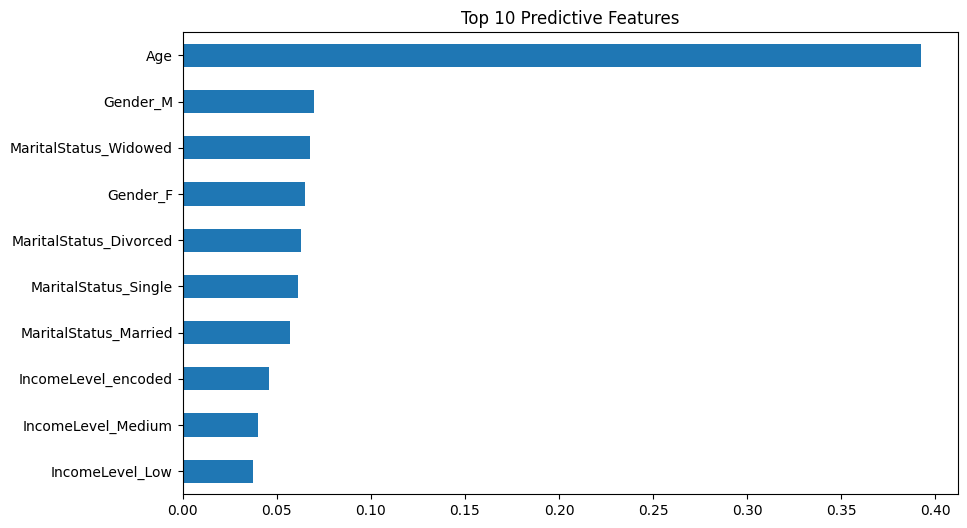

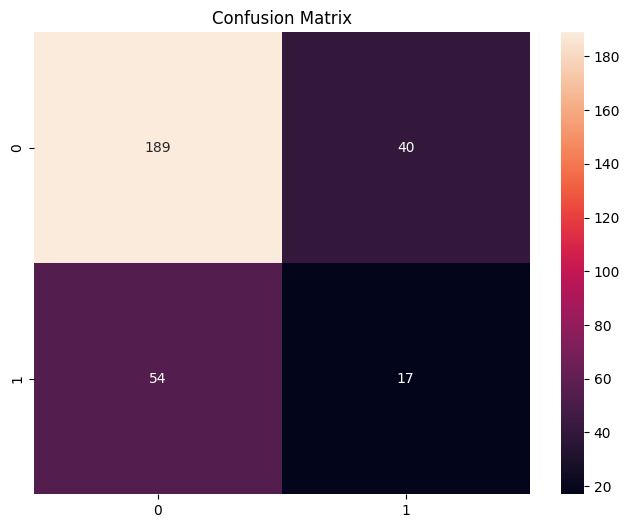

In [16]:
# Generate plots for report
plt.figure(figsize=(10, 6))
pd.Series(performance['feature_importances']).sort_values().tail(10).plot.barh()
plt.title("Top 10 Predictive Features")
plt.savefig('feature_importance.png')

plt.figure(figsize=(8, 6))
sns.heatmap(performance['confusion_matrix'], annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')